In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas

In [7]:
import nengo
import nengo_spa as spa
import numpy as np
import pytry

class StroopTrial(pytry.PlotTrial):
    def params(self):
        self.param('number of dimensions in semantic pointer', D=16)
        self.param('number of each type of stimuli to test', n_stims=2)
        self.param('inter-stimulus interval', t_isi=0.05)
        self.param('stimulus presentation time', t_stim=0.15)
        self.param('direct automaticity', auto_direct=0.0)
        self.param('use neurons', use_neurons=True)
        self.param('decision making system (bg|ia)', decision='bg')
        self.param('threshold for producing an output', output_threshold=0.1)
        self.param('IA decision time', ia_accum_timescale=0.4)
        self.param('attention error', attention_error=0.0)
        
        
    def evaluate(self, p, plt):
        stimuli = []
        for i in range(p.n_stims):
            stimuli.append(('NEUTRAL%d'%i, 'COLOR%d'%i, 'neutral'))
        for i in range(p.n_stims):
            stimuli.append(('COLOR%d'%i, 'COLOR%d'%i, 'congruent'))
        for i in range(p.n_stims):
            stimuli.append(('COLOR%d'%((i+1)%p.n_stims), 'COLOR%d'%i, 'incongruent'))

        vocab = spa.Vocabulary(p.D, pointer_gen=np.random.RandomState(seed=p.seed))
        for i in range(p.n_stims):
            vocab.populate('NEUTRAL%d'%i)
            vocab.populate('COLOR%d'%i)
        vocab.populate('COLOR; WORD')

        model = spa.Network(seed=p.seed)
        with model:
            def word_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][0]
            def color_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][1]
            stim_w = spa.Transcode(word_func, output_vocab=vocab)
            stim_c = spa.Transcode(color_func, output_vocab=vocab) 
            stim_a = spa.Transcode('(1-%g)*COLOR + %g*WORD' % (p.attention_error, p.attention_error), output_vocab=vocab)

            wm = spa.State(vocab)
            
            (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm
            
            if p.auto_direct != 0:
                stim_w*p.auto_direct >> wm
                
                
            speech = spa.State(vocab)
            
            if p.decision == 'bg':
                with spa.ActionSelection() as action_sel:
                    for i in range(p.n_stims):
                        spa.ifmax(spa.dot(wm, spa.sym('COLOR%d'%i)), spa.sym('COLOR%d'%i) >> speech)                
                    spa.ifmax(0.35, spa.sym('0') >> speech)
            elif p.decision == 'ia':
                def reset_func(t):
                    index = int (t / (p.t_stim + p.t_isi))
                    t = t % (p.t_stim + p.t_isi)
                    if t < p.t_isi:
                        return 1
                    else:
                        return 0                                
                reset = nengo.Node(reset_func)
                
                decision = spa.IAAssocMem(vocab, mapping=['COLOR%d'%i for i in range(p.n_stims)],
                                          accum_timescale=p.ia_accum_timescale)
                wm >> decision
                
                nengo.Connection(reset, decision.input_reset)
            else:
                raise Exception('Unknown decision param: %s' %p.decision)
            if not p.use_neurons:
                for ens in model.all_ensembles:
                    ens.neuron_type=nengo.Direct()
                

            p_output = nengo.Probe(wm.output, synapse=0.02)
            p_correct = nengo.Probe(stim_c.output)
            p_speech = nengo.Probe(speech.output, synapse=0.02)
            
            if p.decision == 'bg':
                p_act = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
            elif p.decision == 'ia':
                p_act = nengo.Probe(decision.selection.output, synapse=0.01)
            

        sim = nengo.Simulator(model, progress_bar=p.verbose)
        with sim:
            sim.run(p.n_stims*(p.t_isi+p.t_stim)*3)    

        v = np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output])
        steps = int((p.t_isi+p.t_stim)/sim.dt)
        scores = v[steps-2::steps]
        

        data = sim.data[p_act]
        rts = []
        accuracy = []
        for condition in range(3):
            for i in range(p.n_stims):
                t_start = (p.t_isi+p.t_stim)*i + p.t_isi + condition*(p.t_isi+p.t_stim)*p.n_stims
                t_end = t_start + p.t_stim
                d = data[int(t_start/sim.dt):int(t_end/sim.dt) , i]

                correct = np.max(d) > p.output_threshold
                if correct:
                    rt = np.where(d > p.output_threshold)[0][0]*sim.dt
                else:
                    rt = None

                rts.append(rt)
                accuracy.append(correct)
        
        
        
        
        
        if plt:
            plt.subplot(2, 1, 1)
            plt.plot(sim.trange(), sim.data[p_output].dot(vocab.vectors.T))
            plt.subplot(2, 1, 2)
            if p.decision == 'bg':
                plt.plot(sim.trange(), sim.data[p_act][:,:-1])
            elif p.decision == 'ia':
                plt.plot(sim.trange(), sim.data[p_act])
                
            for i in range(p.n_stims*3):
                plt.axvline(i*(p.t_isi+p.t_stim)+p.t_isi, ls='--')
            
        
        return dict(
            scores=scores,
            stimuli=stimuli,
            neutral=np.mean(scores[:p.n_stims]),
            congruent=np.mean(scores[p.n_stims:p.n_stims*2]),
            incongruent=np.mean(scores[p.n_stims*2:]),
            rts=rts,
            accuracy=accuracy,
            rt_neutral=np.mean(rts[:p.n_stims]),
            rt_congruent=np.mean(rts[p.n_stims:p.n_stims*2]),
            rt_incongruent=np.mean(rts[p.n_stims*2:]),
        )

        

running StroopTrial#20200419-224439-60266b8d


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 0
D = 64
n_stims = 4
t_isi = 0.2
t_stim = 1.0
auto_direct = 0.0
use_neurons = True
decision = 'ia'
output_threshold = 0.1
ia_accum_timescale = 2.0
attention_error = 0.3
accuracy = [True, True, True, True, True, True, True, True, True, True, True, True]
congruent = 0.6896317548564349
incongruent = 0.5494555185865502
neutral = 0.5439659227870516
rt_congruent = 0.46725000000000005
rt_incongruent = 0.5517500000000001
rt_neutral = 0.479
rts = [0.215, 0.546, 0.587, 0.5680000000000001, 0.443, 0.45, 0.47100000000000003, 0.505, 0.493, 0.623, 0.56, 0.531]
scores = array([0.61468866, 0.54534379, 0.50491575, 0.5109155 , 0.74734098,
       0.72548647, 0.68230373, 0.60339585, 0.64838427, 0.44906099,
       0.53139617, 0.56898064])
stimuli = [('NEUTRAL0', 'COLOR0', 'neutral'), ('NEUTRAL1', 'COLOR1', 'neutral'), ('NEUTRAL2', 'COLOR2', 'neutral'), ('NEUTRAL3', 'COLOR3', 'neutral'), ('COLOR0', 'COLOR0', 'congruent'), ('COLOR1', 'COLOR1', 'congruent'), ('COLOR2', 'COLOR2', 'congruent'), ('COLOR3',

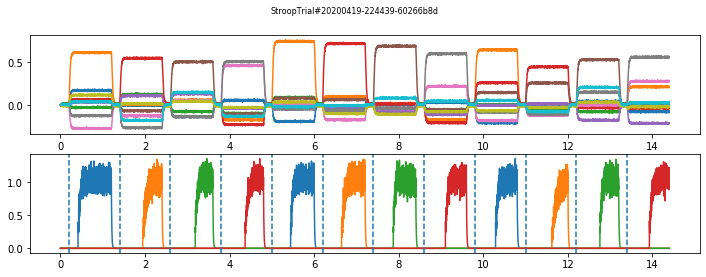

In [15]:
plt.figure(figsize=(12,4))
r = StroopTrial().run(plt=plt, n_stims=4, data_dir=None, seed=0, D=64, auto_direct=0.0, use_neurons=True,
                  decision='ia', ia_accum_timescale=2.0, t_stim=1.0, t_isi=0.2, attention_error=0.3)

running StroopTrial#20200419-224802-ab59b926


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 0
D = 64
n_stims = 4
t_isi = 0.2
t_stim = 1.0
auto_direct = 0.3
use_neurons = True
decision = 'ia'
output_threshold = 0.1
ia_accum_timescale = 2.0
attention_error = 0.0
accuracy = [True, True, True, True, True, True, True, True, True, True, True, True]
congruent = 0.8543154646059976
incongruent = 0.7104357203447238
neutral = 0.7090407906180198
rt_congruent = 0.39975
rt_incongruent = 0.462
rt_neutral = 0.38625000000000004
rts = [0.168, 0.459, 0.47500000000000003, 0.443, 0.382, 0.39, 0.399, 0.428, 0.429, 0.522, 0.46, 0.437]
scores = array([0.74066957, 0.69274295, 0.66810987, 0.73464077, 0.92190612,
       0.87243587, 0.84463182, 0.77828805, 0.78329577, 0.58800159,
       0.70693315, 0.76351237])
stimuli = [('NEUTRAL0', 'COLOR0', 'neutral'), ('NEUTRAL1', 'COLOR1', 'neutral'), ('NEUTRAL2', 'COLOR2', 'neutral'), ('NEUTRAL3', 'COLOR3', 'neutral'), ('COLOR0', 'COLOR0', 'congruent'), ('COLOR1', 'COLOR1', 'congruent'), ('COLOR2', 'COLOR2', 'congruent'), ('COLOR3', 'COLOR3', 'congruent'),

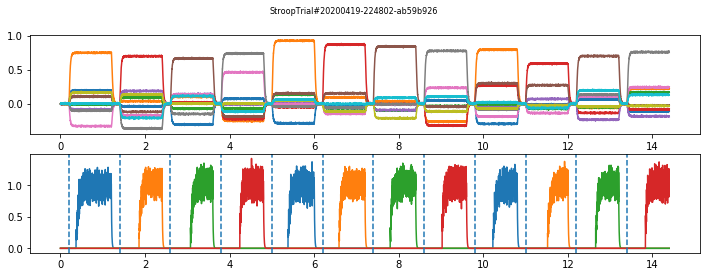

In [16]:
plt.figure(figsize=(12,4))
r = StroopTrial().run(plt=plt, n_stims=4, data_dir=None, seed=0, D=64, auto_direct=0.3, use_neurons=True,
                  decision='ia', ia_accum_timescale=2.0, t_stim=1.0, t_isi=0.2, attention_error=0.0)

In [57]:
for seed in range(10, 20):
    print(seed)
    for auto_direct in [0.0, 0.1, 0.2, 0.3, 0.4]:
        StroopTrial().run(n_stims=8, data_dir='exp2', seed=seed, D=64, verbose=False, auto_direct=auto_direct)        
        StroopTrial().run(n_stims=8, data_dir='exp3', seed=seed, D=64, verbose=False, auto_direct=auto_direct, use_neurons=False)

10


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

11


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=13, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=13, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

12


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity=0.10)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=14, similarity

13


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity

14


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity

15


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity=0.11)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=15, similarity

16
17


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity=0.13)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=17, similarity

18
19


c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity=0.12)
  len(self._key2idx), best_sim))
c:\users\terry\documents\github\nengo_spa\nengo_spa\vocabulary.py:173: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=64, M=16, similarity

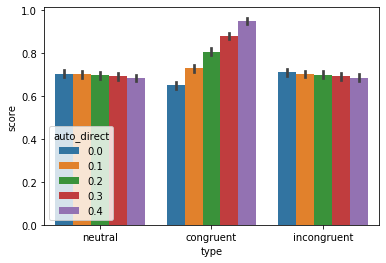

In [58]:
data = []
for d in pytry.read('exp2'):
    score = d['scores']
    stimuli = d['stimuli']
    for i in range(len(score)):
        d2 = dict(d)
        del d2['scores']
        del d2['stimuli']
        d2['score'] = score[i]
        d2['type'] = stimuli[i][2]
        data.append(d2)
df = pandas.DataFrame(data)
seaborn.barplot('type', 'score', hue='auto_direct', data=df)        

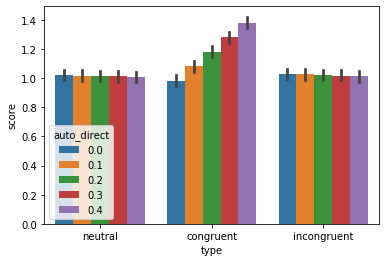

In [59]:
data = []
for d in pytry.read('exp3'):
    score = d['scores']
    stimuli = d['stimuli']
    for i in range(len(score)):
        d2 = dict(d)
        del d2['scores']
        del d2['stimuli']
        d2['score'] = score[i]
        d2['type'] = stimuli[i][2]
        data.append(d2)
df = pandas.DataFrame(data)
seaborn.barplot('type', 'score', hue='auto_direct', data=df)
        